In [8]:
import statsmodels.api as sm
import math
import random
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
from pandas_datareader import wb


## 1. Specify Stocks and weights

In [199]:
stocks = ['XOM','CVX','CRM','TSLA','NFLX','^GSPC'] # Market index is not in the portfolio. It is used as an independent variable for the OLS
endDate = datetime.date(2023,1,1)
startDate = endDate - datetime.timedelta(days=365*5)
#weights = [0.1, 0.8,0.1] # If not using the random asset weight generator below then make sure that the length of the list is 1 less than the length of the 'stocks' list (i.e. don't assign a weight to the market index))

# Set the seed for reproducibility
random.seed(29)
# Generate three random numbers
random_numbers = [random.uniform(0.1/(10**10), 1) for _ in range(len(stocks)-1)]

# Divide each number by their sum
weights = [num / (sum(random_numbers)) for num in random_numbers]
print([f"{stocks} : {round(weights,2)}" for stocks, weights in zip(stocks, weights)])

['XOM : 0.22', 'CVX : 0.14', 'CRM : 0.33', 'TSLA : 0.11', 'NFLX : 0.2']


## 2. Download stock returns from YahooFinance

In [200]:
yf.pdr_override() #This is necessary because Yahoo Finance changed its API, and yfinance provides an updated implementation for fetching data from Yahoo Finance


stock_df_names = [] # List of DFs

def get_data(stocks, start, end):
    
    df_names = [item.replace('.', '') for item in stocks] # Removes '.' in the elements so that they are easier to call
    
    for stock, df_name in zip(stocks, df_names):

        dfs = f'{df_name.lower()}_returns'
        globals()[dfs] = pdr.DataReader(stock,start,end).reset_index()
        stock_df_names.append(dfs)
    
    stockData = pdr.DataReader(stocks, start, end)
    stockData = stockData['Adj Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return stockData, returns, meanReturns, covMatrix

stockData, returns, meanReturns, covMatrix = get_data(stocks, startDate, endDate)

print('Mean Returns during the period:')
print(meanReturns)
print(f'Returns Data for: {stocks} downloaded')
print(f'Returns Data saved in: {stock_df_names}')
returns

# Separate the stocks of the portfolio and the market index(i.e. SP500), which will be used as a proxy for market returns.
market_data = returns[['^GSPC']]
returns = returns.drop('^GSPC',axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  6 of 6 completed
Mean Returns during the period:
CRM      0.000491
CVX      0.000700
NFLX     0.000773
TSLA     0.002243
XOM      0.000643
^GSPC    0.000376
dtype: float64
Returns Data for: ['XOM', 'CVX', 'CRM', 'TSLA', 'NFLX', '^GSPC'] downloaded
Returns Data saved in: ['xom_returns', 'cvx_returns', 'crm_returns', 'tsla_returns', 'nflx_returns', '^gspc_returns']


In [201]:
daily_returns = returns
# Calculate monthly returns

daily_returns['Portfolio Return'] = np.dot(returns[returns.columns].values, weights)
monthly_returns  = daily_returns.resample('M').sum()

## 3. Independent Variables

In [202]:
#Calculate monthly_returns
market_returns = market_data.resample('M').sum()
market_returns.rename(columns = {'^GSPC':'Market Return'}, inplace=True)

# Download Macro Vars
macro_data = pdr.get_data_fred(['FEDFUNDS','CPIAUCNS'], startDate, endDate)
#FEDFUNDS: US Treasury Rate
#CPIAUCNS: CPI

# Change the date index to the last day of the month. Impact of interest rates (set at the start of the month) is relevant to stock performance before a new base rate is announced 
macro_data.index = macro_data.index + pd.offsets.MonthEnd(0)

ind_vars = pd.merge(monthly_returns['Portfolio Return'], macro_data,how='inner',left_index = True, right_index = True)
ind_vars = market_returns.join([macro_data], how='inner')

## 4. Linear Regression

In [203]:
ols_data = pd.merge(monthly_returns['Portfolio Return'], ind_vars,how='inner',left_index = True, right_index = True)

In [204]:
# Define dependent variable (portfolio returns)
y = ols_data['Portfolio Return']

# Define independent variables
x = ind_vars
x = sm.add_constant(x) # Add placeholder for the intercept term

# Fit an OLS model to the time series
model = sm.OLS(y, x)
results = model.fit()


## Output

                            OLS Regression Results                            
Dep. Variable:       Portfolio Return   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     31.40
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           5.80e-12
Time:                        23:11:21   Log-Likelihood:                 93.708
No. Observations:                  59   AIC:                            -179.4
Df Residuals:                      55   BIC:                            -171.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0210      0.117      0.179

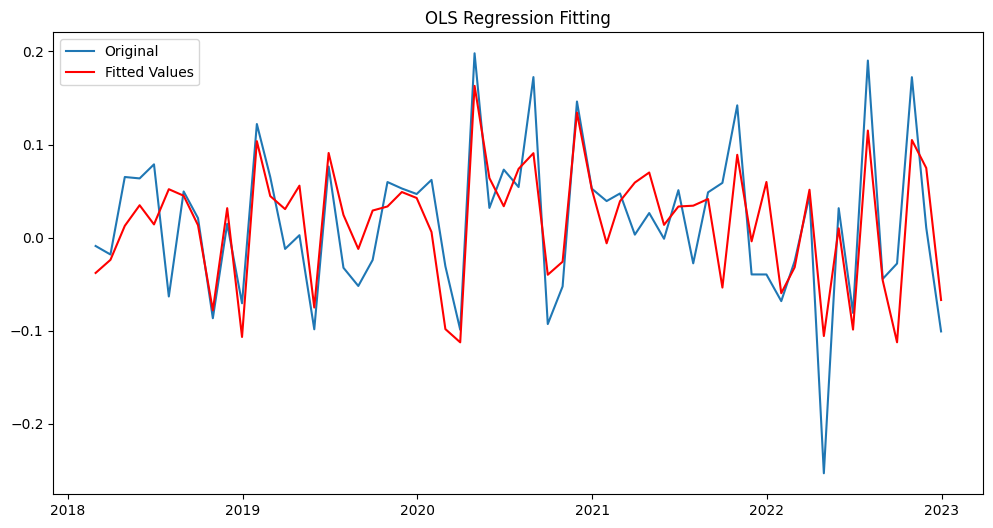

In [205]:
# Print model summary
print(results.summary())

# Plot the original time series and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y, label='Original')
plt.plot(results.fittedvalues, color='red', label='Fitted Values')
plt.legend(loc='upper left')
plt.title('OLS Regression Fitting')
plt.show()